# 1. 라이브러리 불러오기 & 데이터 준비

In [1]:

import kagglehub
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import seaborn as sns

path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

train_dir = os.path.join(path, "chest_xray", "train")
val_dir = os.path.join(path, "chest_xray", "val")
test_dir = os.path.join(path, "chest_xray", "test")

Using Colab cache for faster access to the 'chest-xray-pneumonia' dataset.
Using device: cuda
Class names: ['NORMAL', 'PNEUMONIA']
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 131MB/s]


Epoch 1/5, Loss: 0.1223, Val Acc: 56.25%
Epoch 2/5, Loss: 0.0665, Val Acc: 62.50%
Epoch 3/5, Loss: 0.0527, Val Acc: 87.50%
Epoch 4/5, Loss: 0.0479, Val Acc: 87.50%
Epoch 5/5, Loss: 0.0380, Val Acc: 100.00%
Test Accuracy: 88.14%


# 2. 데이터 전처리 & DataLoader

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomRotation(20),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ]),
}

train_dataset = datasets.ImageFolder(train_dir, transform=data_transforms['train'])
val_dataset   = datasets.ImageFolder(val_dir,   transform=data_transforms['val'])
test_dataset  = datasets.ImageFolder(test_dir,  transform=data_transforms['test'])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

class_names = train_dataset.classes
print("Class names:", class_names)

# 3. 모델 정의 (ResNet18 전이학습)

In [ ]:
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

model = model.to(device)

# 4. 손실 함수 & 옵티마이저

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# 5. 학습 루프

In [ ]:
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_acc = 100 * correct / total
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}, Val Acc: {val_acc:.2f}%")

# 6. 테스트 정확도 평가

In [ ]:
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

print(f"Test Accuracy: {100 * correct / total:.2f}%")

# 7. 상세 평가 (Accuracy, Precision, Recall, F1-score)

📊 Test Performance Metrics
Accuracy : 0.8814
Precision: 0.8435
Recall   : 0.9949
F1-score : 0.9129

Detailed Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.99      0.69      0.81       234
   PNEUMONIA       0.84      0.99      0.91       390

    accuracy                           0.88       624
   macro avg       0.92      0.84      0.86       624
weighted avg       0.90      0.88      0.88       624



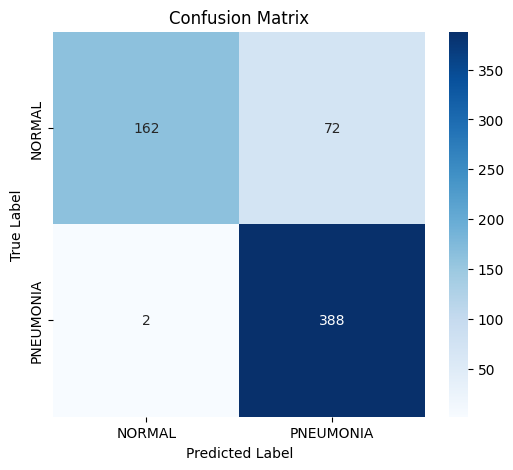

In [2]:
y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

acc  = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average="binary")
rec  = recall_score(y_true, y_pred, average="binary")
f1   = f1_score(y_true, y_pred, average="binary")

print("📊 Test Performance Metrics")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-score : {f1:.4f}")

print("\nDetailed Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()